In [1]:
#Load the libraries.
import warnings
import numpy as np
import pandas as pd
from numpy import random
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import Quandl
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sma
import patsy
from statsmodels.graphics.api import abline_plot
import numpy.linalg as linalg
import pymc3 as pm
from mpl_toolkits.mplot3d import Axes3D
warnings.simplefilter('ignore')
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)
%matplotlib inline

##Simulating the posterior probabilty distributions of $\alpha$ and $\beta$ from the CAPM.
Campare to MCMC simluation on class, our homework only have few changes.
- Transfer prior distribution of $\alpha$ from $N(0,20)$ to $U(-2,2)$
- Transfer prior distribution of $\beta$ from $N(0,20)$ to $U(0,4)$

In [2]:
# Read in AAPL and NASDAQ and generate returns.

aapl_all = Quandl.get("YAHOO/AAPL", trim_start="2010-1-1", trim_end="2015-09-18")
nasdaq_all = Quandl.get("NASDAQOMX/COMP", trim_start="2010-1-1", trim_end="2015-09-18")
aapl = aapl_all['Adjusted Close']
nasdaq = nasdaq_all['Index Value']
aapl_returns = np.log(aapl / aapl.shift(1))
nasdaq_returns = np.log(nasdaq / nasdaq.shift(1))
aapl_returns = aapl_returns.dropna()
nasdaq_returns = nasdaq_returns.dropna()

In [3]:
# Start with frequentist approach.
# Conduct hypothesis testing.

aapl_r = pd.DataFrame(aapl_returns)
nasdaq_r = pd.DataFrame(nasdaq_returns)
data = pd.merge(nasdaq_r, aapl_r, left_index=True, right_index=True)
data.rename(columns={'Index Value':'nasdaq', 'Adjusted Close':'aapl'}, inplace=True)
mod = smf.ols(formula='aapl ~ nasdaq', data = data).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                   aapl   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     955.2
Date:                Wed, 14 Oct 2015   Prob (F-statistic):          3.49e-161
Time:                        15:04:09   Log-Likelihood:                 4194.7
No. Observations:                1437   AIC:                            -8385.
Df Residuals:                    1435   BIC:                            -8375.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0005      0.000      1.362      0.1

## Samples on Class

In [4]:
# Turn to the Bayesian approach where we will simulate 
# the posterior probability distributions of alpha and beta from CAPM.  
# Sigma is the variance, which we can ignore.
# We will show how hypothesis testing using a Bayesian approach is 
# straightforward and could be the basis of decision making.

# This is the syntax for PyMC3, 
# the Python library that allows one to do canned Bayesian estimation.
# See https://pymc-devs.github.io/pymc3/getting_started/.
# If you were to use this with different returns data,
# just replace 'nasdaq_returns' with the returns to the market
# and 'aapl_returns' with the returns to the particular stock

with pm.Model() as model:
    # alpha, beta, and sigma are the hyperparameters over which we have our priors, in this case they are flat priors.    
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta = pm.Normal('beta', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    # y_est is the specification of the Bayesian model to be estimated.  It is simply our CAPM.
    y_est = alpha + beta * nasdaq_returns
    
    # likelihood is the likelihood function, here it is normal to be used with conjugate priors.    
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=aapl_returns)
    
    # We use the Maximum a Posteriori (MAP) values as starting values for the MCMC sampling.
    start = pm.find_MAP()
    step = pm.NUTS(state=start)
    trace = pm.sample(1000, step, start=start, progressbar=True)

ERROR (theano.gof.opt): SeqOptimizer apply <theano.tensor.opt.FusionOptimizer object at 0x10a518710>
ERROR:theano.gof.opt:SeqOptimizer apply <theano.tensor.opt.FusionOptimizer object at 0x10a518710>
ERROR (theano.gof.opt): Traceback:
ERROR:theano.gof.opt:Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/Users/luke/anaconda/lib/python2.7/site-packages/theano/gof/opt.py", line 195, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/Users/luke/anaconda/lib/python2.7/site-packages/theano/gof/opt.py", line 81, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/Users/luke/anaconda/lib/python2.7/site-packages/theano/tensor/opt.py", line 5498, in apply
    new_outputs = self.optimizer(node)
  File "/Users/luke/anaconda/lib/python2.7/site-packages/theano/tensor/opt.py", line 5433, in local_fuse
    n = OP(C)(*inputs).owner
  File "/Users/luke/anaconda/lib/python2.7/site-packages/theano/tensor/elemwise.py", line 496, in __init__
    scalar_op

 [-----------------100%-----------------] 1000 of 1000 complete in 6.9 sec

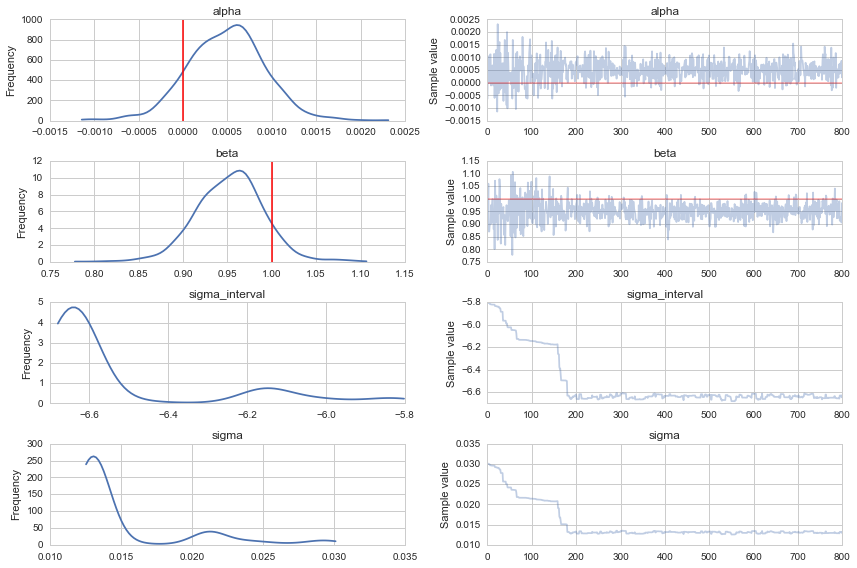

In [5]:
# Show results after burn in of 200 MCMC replications.

fig = pm.traceplot(trace[199:1000], lines={'alpha': 0, 'beta': 1})
plt.figure(figsize = (12, 10))

In [ ]:
# Having simulated the entire posterior probability distributions, 
# we can calculate useful metrics.

# Start with averages and 95% credible intervals.
# Note their simularity to the least squares results.

print ("Average alpha and its 95% credible interval are:", np.mean(trace['alpha'][199:1000]), np.percentile(trace['alpha'][199:1000], (2.5, 97.5)))
print ("Average beta and its 95% credible interval are:", np.mean(trace['beta'][199:1000]), np.percentile(trace['beta'][199:1000], (2.5, 97.5)))
print ()
print (mod.summary())

In [9]:
# Test two valuable hypotheses.
# alpha > 0
# beta < 1
# These are key inputs to decision making.

print ("The probability that alpha is greater than zero is", np.mean(trace['alpha'][199:1000] > 0.0))
print ("The probability that beta is less than one is", np.mean(trace['beta'][199:1000] < 1.0))

('The probability that alpha is greater than zero is', 0.89762796504369535)
('The probability that beta is less than one is', 0.92009987515605496)
